In [1]:
# imports .. can be ignored
from pydub import AudioSegment
from sample import loadData, calculation
import IPython.display as ipd
import time
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import librosa as lr
import os
import soundfile as sf

# Notebook to present my progress
## 1. Let's have a look at all audio file in the time domain
_NOTE_: raw data from Mr. Schlenke (samplerate = 44KHz)

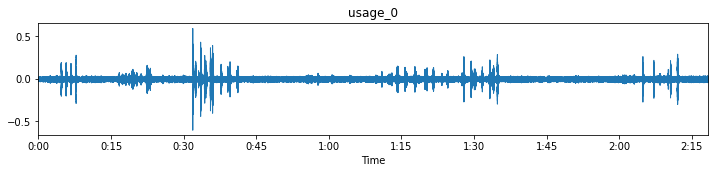

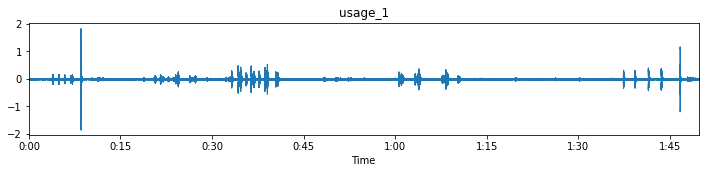

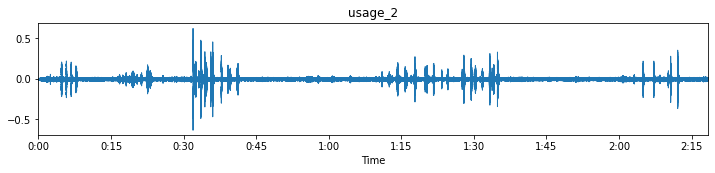

In [2]:
index = 1
for file in os.listdir(loadData.DATA_RAW):
    lr_data, sr = lr.load(loadData.DATA_RAW+file,sr=44100)
    plt.figure(figsize=(12,7))
    plt.subplot(3,1,index)
    lr.display.waveplot(lr_data*10,sr)
    plt.title("%s" % file.replace(".wav",""))
    index += 1

You can see that we have a lot of silent frames.
___

## Let's listen to:
_NOTE_: These chunks are not denoised.
### 1. the silent frame / noise (first Plot 0:08-0:13)
This is the first chunk from ```usage_0.wav``` that will be created after slicing the raw audio into 5 sec duration.

In [3]:
silent_0_0 = "/home/timo/Musik/usage_0_0.wav"
ipd.Audio(silent_0_0)

### 2. the first 8 sec (all Plots 0:00-0:08)
That's why I want to cut the first 8 sec, while slicing the data into chunk of 5 sec.

In [4]:
file = "usage_0.wav"
raw_audio = AudioSegment.from_file(loadData.DATA_RAW+file)
removed_segment = raw_audio[:8000]

path_to_save = "/home/timo/Musik/removed_segment.wav"
removed_segment.export(path_to_save, format="wav")
ipd.Audio(path_to_save)

### 3. some "activitys" (first Plot 0:13-0:18)
This is the sixth chunk from ```usage_0.wav``` that will be created after slicing the raw audio into 5 sec duration.

In [5]:
activity_0_5 = "/home/timo/Musik/usage_0_5.wav"
ipd.Audio(activity_0_5)

---

# My way of preprocessing
## 1. Resample audio files to 16KHz + one channel (dimension reduction)
_NOTE_: I have written this function, samplerate is hard coded in constants.py, but can be easily changed

In [6]:
# Some statistics
mean_duration = np.mean(np.array(loadData.getDuration(loadData.DATA_RAW))) / 60

t0 = time.time()
loadData.resampledData(loadData.DATA_RAW,loadData.DATA_RESAMPLED)
time_total = time.time()-t0
print("For 3 .wav files with average duration of %.6s min, we need %.6s sec" % (mean_duration, time_total))

3 files from ../use_data/raw/ resampled to 16000 Hz and copied into ../use_data/resampled/
For 3 .wav files with average duration of 2.1472 min, we need 10.230 sec


## 2. Reduce static noise
_NOTE_: This is a python implementation based on the audacity noise reduction [algorithm](https://timsainburg.com/noise-reduction-python.html).

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

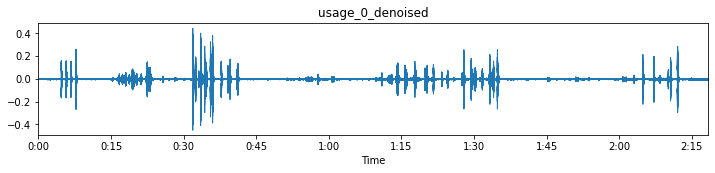

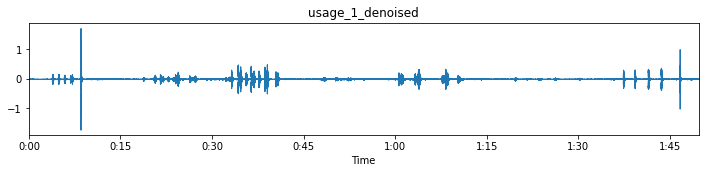

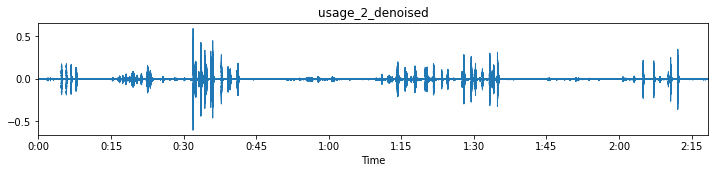

In [7]:
import noisereduce

# Let's take the noise/silent frame you have been listening to
noise, sr = lr.load(silent_0_0,mono=True,sr=16000)
index = 1
for file in os.listdir(loadData.DATA_RESAMPLED):
    audio, sr = librosa.load(loadData.DATA_RESAMPLED+file,sr=loadData.SAMPLE_RATE,mono=True)
    reduced_noise = noisereduce.reduce_noise(y=audio,sr=loadData.SAMPLE_RATE,y_noise=noise,stationary=True)
    plt.figure(figsize=(12,7))
    plt.subplot(3,1,index)
    lr.display.waveplot(reduced_noise*10,sr=sr)
    plt.title("%s_denoised" %file.replace(".wav",""))
    plt.savefig("audio.png",dpi = 600, bbox_inches="tight",transparent=True)
    index+=1
    sf.write(loadData.DATA_RESAMPLED+file,reduced_noise,loadData.SAMPLE_RATE)

### 3. Slice data into 5 sec chunk and cut the first 8 sec
_NOTE_: I have written this function, this does not affect the quality of the audio.
Duration time is hard coded in constants.py and can be changed easily.

In [8]:
t0 = time.time()
loadData.sliceAudio(loadData.DATA_RESAMPLED,loadData.DATA_PROCESSED)
time_total = time.time()-t0
print("For 3 .wav files with average duration of %.6s min, we need %.6s sec" % (mean_duration, time_total))

usage_0.wav got sliced into 27 pieces and exported
Duration of last chunk is 0.38 sec file will be ignored
------------------------------------------------------------
usage_1.wav got sliced into 21 pieces and exported
Duration of last chunk is 1.72 sec file will be ignored
------------------------------------------------------------
usage_2.wav got sliced into 27 pieces and exported
Duration of last chunk is 0.4 sec file will be ignored
------------------------------------------------------------
For 3 .wav files with average duration of 2.1472 min, we need 0.0854 sec


---
### Perfect lets have a look at the results

In [9]:
silent,_ = lr.load(loadData.DATA_PROCESSED+"usage_0_0.wav",sr=loadData.SAMPLE_RATE)
print("Reduced noise")
ipd.Audio(loadData.DATA_PROCESSED+"usage_0_0.wav")

Reduced noise


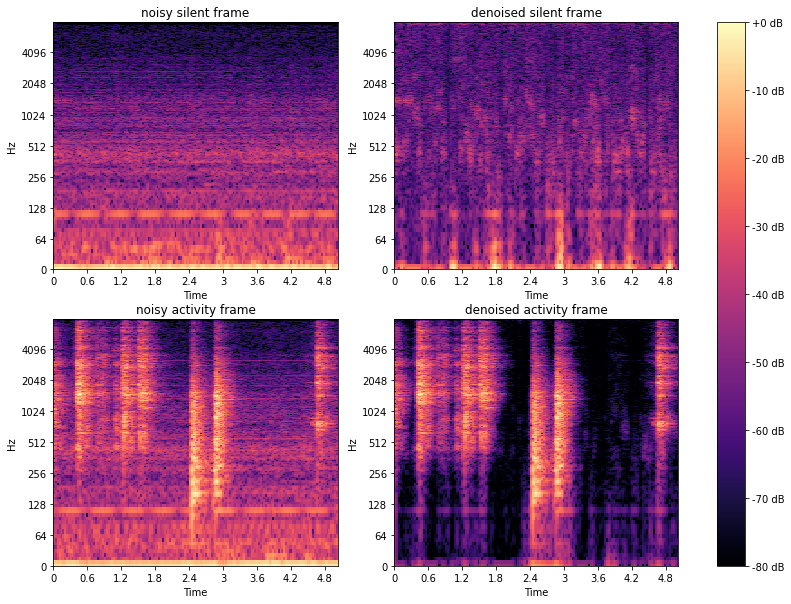

In [10]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(14,10))

# silent frame before denoising
D_sn = lr.amplitude_to_db(np.abs(lr.stft(noise)), ref=np.max)
img = lr.display.specshow(D_sn,y_axis="log", x_axis="time",sr=loadData.SAMPLE_RATE, ax=ax[0,0])
plt.sca(ax[0,0])
plt.title("noisy silent frame")

# silent frame after denoising
D_s = lr.amplitude_to_db(np.abs(lr.stft(silent)), ref=np.max)
img_1 = lr.display.specshow(D_s,y_axis="log", x_axis="time",sr=loadData.SAMPLE_RATE, ax=ax[0,1])
plt.sca(ax[0,1])
plt.title("denoised silent frame")

# noisy activity before denoising
activity_noise, _ = lr.load(activity_0_5,sr = loadData.SAMPLE_RATE)
D_a_n = librosa.amplitude_to_db(np.abs(librosa.stft(activity_noise)), ref=np.max)
img_2 = librosa.display.specshow(D_a_n,y_axis="log", x_axis="time",sr=loadData.SAMPLE_RATE,ax=ax[1,0])
plt.sca(ax[1,0])
plt.title("noisy activity frame")

# denoised activity after denoising
activity_denoised, _ = lr.load(loadData.DATA_PROCESSED+"usage_0_5.wav",sr = loadData.SAMPLE_RATE)
D_a = librosa.amplitude_to_db(np.abs(librosa.stft(activity_denoised)), ref=np.max)
img_3 = librosa.display.specshow(D_a,y_axis="log", x_axis="time",sr=loadData.SAMPLE_RATE,ax=ax[1,1])
plt.sca(ax[1,1])
plt.title("denoised activity frame")
# fancy colorbar
fig.colorbar(img,ax=ax,format="%+2.f dB")

### 4. Add some new "Haushaltsrauschen" to a frame
_NOTE_: This should be an example input audio frame for the autoencoder.

In [11]:
# calculate default SNR
mean_noise = calculation.meanPower(noise)
mean_silent = calculation.meanPower(activity_denoised)
print(calculation.snr(mean_silent,mean_noise))

4.384322464466095


In [12]:
# We want to add this
dishwasher=loadData.NOISE_PROCESSED+"dishwasher_2_10.wav"
# street = loadData.NOISE_PROCESSED+"street_5_0.wav"
print("dishwasher noise")
ipd.Audio(dishwasher)

dishwasher noise


In [13]:
# load two kind of noise
noise_dishwasher, _ = lr.load(dishwasher,sr=loadData.SAMPLE_RATE,mono=True)
noise_vacuuming, _ = lr.load(loadData.NOISE_PROCESSED+"vacuuming_4_3.wav",sr=loadData.SAMPLE_RATE,mono=True)

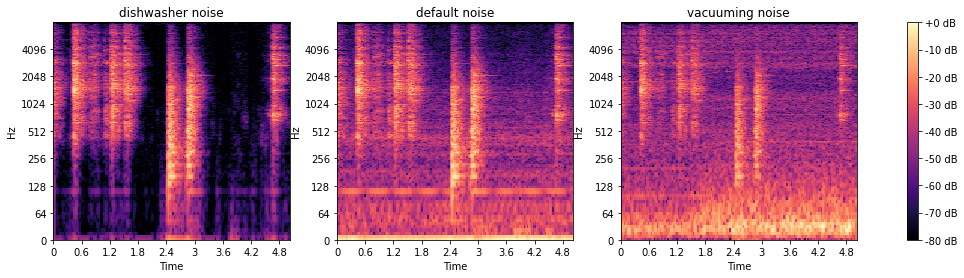

In [14]:
# Add noise to audio clip with an snr = 0dB
dishwasher_activitie = calculation.add_noise_zero_db(activity_denoised,noise_dishwasher)
vacuuming_activitie = calculation.add_noise_zero_db(activity_denoised,noise_vacuuming)

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(18,4))

D = librosa.amplitude_to_db(np.abs(librosa.stft(dishwasher_activitie)), ref=np.max)
img = librosa.display.specshow(D_a,y_axis="log", x_axis="time",sr=loadData.SAMPLE_RATE,ax=ax[0])
plt.sca(ax[0])
plt.title("dishwasher noise")

D_w = librosa.amplitude_to_db(np.abs(librosa.stft(activity_noise)), ref=np.max)
img_2 = librosa.display.specshow(D_w,y_axis="log", x_axis="time",sr=loadData.SAMPLE_RATE,ax=ax[1])
plt.sca(ax[1])
plt.title("default noise")

D_s = librosa.amplitude_to_db(np.abs(librosa.stft(vacuuming_activitie)), ref=np.max)
img_3 = librosa.display.specshow(D_s,y_axis="log", x_axis="time",sr=loadData.SAMPLE_RATE,ax=ax[2])
plt.sca(ax[2])
plt.title("vacuuming noise")
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [15]:
sf.write(loadData.NOISE_PROCESSED+"vacuuming_activitie.wav",vacuuming_activitie,loadData.SAMPLE_RATE)
print("activitie with vacuuming noise")
ipd.Audio(loadData.NOISE_PROCESSED+"vacuuming_activitie.wav")

activitie with vacuuming noise
